In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D , Flatten , Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2  import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from PIL import Image
import PIL

C:\Users\Ravindra Singh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Ravindra Singh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Ravindra Singh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Ravindra Singh\anaconda3\lib\site-packages\tensorflow\python\framework

In [6]:
# initialize the initial Learning rate , number of the epoch to train far 
# batch size
INIT_LR = 1e-4
EPOCHS = 10
BS = 32
DIRECTORY= r"C:\Users\Ravindra Singh\Documents\python\CNN\Facemask_Detection\dataset"

In [7]:
data =[]
labels =[]

for category in os.listdir(DIRECTORY):
    path = os.path.join(DIRECTORY ,category)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image = load_img(img_path, target_size=(224,224))
        image = img_to_array(image)
        image = preprocess_input(image)
        
        data.append(image)
        labels.append(category)
print(labels[:10])


C:\Users\Ravindra Singh\anaconda3\lib\site-packages\PIL\Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


['without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask']


In [4]:
# perform onehot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data,dtype = 'float32')
labels = np.array(labels)

In [5]:
labels[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size = 0.2,random_state=42) 

In [7]:
X_train[0].shape

(224, 224, 3)

In [10]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range = 20, 
    zoom_range = 0.15, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range =0.15, 
    horizontal_flip =True, 
    
    fill_mode="nearest")

In [11]:
# load the mobileNetV2 network , ensuring the head FC layers sets are Leftoff
baseModel = MobileNetV2(weights="imagenet", include_top =False, input_tensor =Input(shape=(224,224,3)))

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\Ravindra Singh\anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [12]:
# constract the head of the model that will be placed on the top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size =(7,7))(headModel)
headModel = Flatten(name="Flatten")(headModel)
headModel = Dense(128,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)
baseModel.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalizationV1) (None, 112, 112, 32) 128         Conv1[0][0]                 

In [13]:
model = Model(inputs=baseModel.input, outputs =headModel)

In [14]:
# loop over all layers in the base model and freeze them 
for layer in baseModel.layers:
    layer.trainable =False

In [15]:
# compile our model 
print("[INFO] compiling model..")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=['accuracy'])

[INFO] compiling model..


In [16]:
print("[INFO] training head..")
H = model.fit(
    aug.flow(X_train,y_train, batch_size = BS),
    steps_per_epoch=len(X_train)//BS,
    validation_data=(X_test,y_test),
    validation_steps=len(X_test)//BS,
    epochs =EPOCHS)

[INFO] training head..
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
80/80 [==============================] - 887s 11s/step - loss: 0.5808 - acc: 0.7082 - val_loss: 0.4592 - val_acc: 0.7906
Epoch 2/10
80/80 [==============================] - 1565s 20s/step - loss: 0.3145 - acc: 0.8727 - val_loss: 0.3985 - val_acc: 0.8375
Epoch 3/10
80/80 [==============================] - 723s 9s/step - loss: 0.2291 - acc: 0.9125 - val_loss: 0.3813 - val_acc: 0.8594
Epoch 4/10
80/80 [==============================] - 3726s 47s/step - loss: 0.1892 - acc: 0.9344 - val_loss: 0.3743 - val_acc: 0.8641
Epoch 5/10
80/80 [==============================] - 1129s 14s/step - loss: 0.1638 - acc: 0.9398 - val_loss: 0.3286 - val_acc: 0.8813
Epoch 6/10
80/80 [==============================] - 1173s 15s/step - loss: 0.1405 - acc: 0.9512 - val_loss: 0.3187 - val_acc: 0.8828
Epoch 7/10
80/80 [==============================] - 1017s 13s/step - loss: 0.1413 - acc: 0.9418 - val_loss: 0.3671 - val_acc: 0.8781
E

In [17]:
# make predictions on the testing set
print("[INFO] evaluting networks...")
pred = model.predict(X_test,batch_size=BS)

[INFO] evaluting networks...


In [19]:
pred

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,

In [18]:
# for each image in the testing set we need to find out the index of the label
#with corresponding largets predictions probability
pred = np.argmax(pred, axis = 1)
# showa nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), pred, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.81      0.88       297
without_mask       0.86      0.98      0.91       343

   micro avg       0.90      0.90      0.90       640
   macro avg       0.92      0.90      0.90       640
weighted avg       0.91      0.90      0.90       640



In [20]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.h5")

[INFO] saving mask detector model...


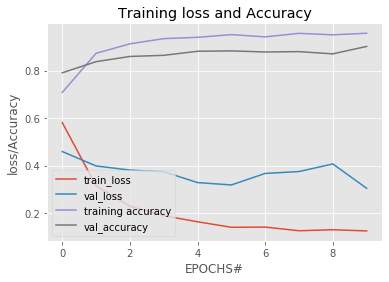

In [21]:
# plot the training and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,N),H.history["loss"],label="train_loss")
plt.plot(np.arange(0,N),H.history["val_loss"],label="val_loss")
plt.plot(np.arange(0,N),H.history['acc'], label='training accuracy')
plt.plot(np.arange(0,N),H.history['val_acc'],label='val_accuracy')
plt.title("Training loss and Accuracy")
plt.xlabel("EPOCHS#")
plt.ylabel("loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")